In [36]:
import random
import json
import re
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

random.seed(6)
np.random.seed(6)


# Experiment - New Version of Gemma3:4b on chat mode

This is the usual experiment of MCQA on ground tuth but with the new version of Gemma3, optimized for quantization.

**Parameters:**
- model: Gemma3 4b
- system prompt: MCQ_system_promtp_ZS_CoT.txt
- user_prompt: MCQ_user_prompt_ZS_CoT_v2.txt
- temperature: 0.1
- sampling method: (default) top-p (p=0.9)


**Results:**  
Marginal improve of ~1-2% with respect to the old model

## Prompts

In [37]:
os.listdir()


['blame.txt',
 'week_0224_llama8b_as_judge.ipynb',
 'hallucinations_investigation.ipynb',
 'resp_analysis.ipynb',
 'resp_analysis2.ipynb',
 'resp_analysis3.ipynb',
 'graph.gv.png',
 'resp_analysis5.ipynb',
 'resp_analysis6_deepseek.ipynb',
 'resp_analysis6_deepseek7b.ipynb',
 'resp_analysis6_llama3b.ipynb',
 'resp_analysis6_llama8b.ipynb',
 'resp_analysis6_phi3.ipynb',
 'resp_analysis4_ZS.ipynb',
 'resp_analysis4_OS.ipynb',
 'week_0224_correlation_llama3bvs8b.ipynb',
 'week_0224_llama3b_bias_check.ipynb',
 'week_0234_oneshot_nohtml_tags.ipynb',
 'week_0303_llama8b_as_judge_improving_correlation.ipynb',
 'week_0303_resp_analysis6_llama8b_regex_extract_last.ipynb',
 'week_0310_llama8b_as_judgeon_extracted_answers.ipynb',
 'week_0317_zs_cot_chat_prompting_gemma3_12b.ipynb',
 'week_0317_zs_cot_chat_prompting_gemma3_4b.ipynb',
 'week_0317_zs_cot_chat_prompting_llama3b.ipynb',
 'week_0317_zs_cot_chat_prompting_llama8b.ipynb',
 'week_0421_zs_cot_chat_prompting_gemma3_27b.ipynb',
 'week_0408_z

In [38]:
with open('../data/prompts/zero-shot-cot/MCQ_system_prompt_ZS_CoT.txt', 'r') as f:
    pr = f.read()

print(pr)


You need to respond to reasoning questions by making logical inference on sequence of Scene-Graphs extracted from frames belonging to a video, called a Spatio-Temporal Scene Graph.

IMPORTANT CLARIFICATIONS:
- You will receive a question and Spatio-Temporal Scene-Graph
- Each Scene-Graph is a static symbolic representation of the scene unfolding in the frame
- The Scene-Graphs are ordered chronologically
- The Scene-Graph is represented as a set of tuple in the format: subject - relationship - object
- The Spatio-Temporal Scene-Graph is a cornologically sorted list of Scene-Graphs

INSTRUCTIONS:
- Read the entire Spatio-Temporal Scene-Graphs in chronological order and pay attention at the order of how events unfold.
- Read the question and reason about the answer step by step.
- In your answer include key events or relationships that help you in determing the correct answer.
- Be careful to reproduce the chosen alternative as it is presented.


In [39]:
with open('../data/prompts/zero-shot-cot/MCQ_user_prompt_ZS_CoT_v2.txt', 'r') as f:
    pr = f.read()

print(pr)


Please carefully read the following Spatio-Temporal Scene Graph delimited by the <STSG> tags and provide an answer to the question below:

<STSG>
{stsg}
</STSG>

Given the following question:
<Q>
{question}
<Q>

And the following alternatives:
<Alternatives>
A. {c1}
B. {c2}
C. {c3}
D. {c4}
</Alternatives>

Provide an answer to the above question reasoning step by step on the Spatio-Temporal Scene-Graph (STSG) and choosing one of the alternatives.


In [40]:
reply = """\
Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.\
"""

print(reply)


Therefore the final answer is?

Your response must be provided in valid JSON format as follows:
{"answer": "your complete answer here"}

IMPORTANT: Always include both the letter (A, B, C, D, etc.) AND the full text of the answer in your response.
Do not abbreviate or shorten the answer. For example, if the correct answer is "A. the laptop", your response 
should be {"answer": "A. the laptop"}, not {"answer": "laptop"} or {"answer": "A"}.


Let's load the ground truth from the `STAR_QA_question_and_stsg_val.json` file where we extracted QA and spatio-temporal scene graphs

In [41]:
ground_truth = []

with open('../data/datasets/STAR_QA_and_stsg_val.json') as f:
    data = json.load(f)
    ground_truth = [{
        'id': sample['question_id'],
        'question': sample['question'],
        'choices': sample['choices'],
        'num': sample['answer'],
        'text': sample['choices'][str(sample['answer'])]
    } for sample in data]


# we keep num as str so we can directrly access choices dictionaries
gt_df = pd.DataFrame(ground_truth).astype({'id': 'string', 'num': 'string', 'text': 'string'})
gt_df.set_index('id', inplace=True)
gt_df


,question,choices,num,text
id,,,,
Interaction_T1_13,Which object was tidied up by the person?,"{'0': 'The closet/cabinet.', '1': 'The blanket...",2,The clothes.
Interaction_T1_14,Which object was tidied up by the person?,"{'0': 'The blanket.', '1': 'The table.', '2': ...",2,The clothes.
Interaction_T1_31,Which object was thrown by the person?,"{'0': 'The pillow.', '1': 'The bag.', '2': 'Th...",2,The clothes.
Interaction_T1_32,Which object was put down by the person?,"{'0': 'The food.', '1': 'The shoe.', '2': 'The...",1,The shoe.
Interaction_T1_40,Which object was tidied up by the person?,"{'0': 'The broom.', '1': 'The closet/cabinet.'...",1,The closet/cabinet.
...,...,...,...,...
Feasibility_T6_1453,What is the person able to do after taking the...,"{'0': 'Wash the table.', '1': 'Take the box.',...",0,Wash the table.
Feasibility_T6_1454,What is the person able to do after walking th...,"{'0': 'Take the towel.', '1': 'Throw the bag.'...",0,Take the towel.
Feasibility_T6_1455,What is the person able to do after walking th...,"{'0': 'Throw the bag.', '1': 'Wash the table.'...",1,Wash the table.


## Loading predicted answers evaluation

In [42]:
predictions = []
with open('../outputs/responses_gemma3:4b_VQA_20250502_18:55:99.jsonl', mode='r', encoding='utf-8', errors='strict') as f:
    predictions = [json.loads(line) for line in f.readlines()]

# transforming the id key from `qid` to `id` for consistency and `response` to `answer`
predictions_df = pd.DataFrame(predictions, dtype='string').rename(columns={'qid':'id', 'response':'answer'})
predictions_df.set_index('id', inplace=True)
predictions_df


,chat_history
id,
Interaction_T3_2531,"[{'role': 'user', 'content': ' You will rec..."
Interaction_T1_2219,"[{'role': 'user', 'content': ' You will rec..."
Sequence_T4_1348,"[{'role': 'user', 'content': ' You will rec..."
Sequence_T4_4702,"[{'role': 'user', 'content': ' You will rec..."
Sequence_T1_3418,"[{'role': 'user', 'content': ' You will rec..."
...,...
Interaction_T2_5713,"[{'role': 'user', 'content': ' You will rec..."
Interaction_T1_2453,"[{'role': 'user', 'content': ' You will rec..."
Sequence_T2_3178,"[{'role': 'user', 'content': ' You will rec..."


In [43]:
predictions_df['chat_history'] = \
    predictions_df['chat_history'] \
    .apply(lambda x: eval(x))

predictions_df


,chat_history
id,
Interaction_T3_2531,"[{'role': 'user', 'content': ' You will rec..."
Interaction_T1_2219,"[{'role': 'user', 'content': ' You will rec..."
Sequence_T4_1348,"[{'role': 'user', 'content': ' You will rec..."
Sequence_T4_4702,"[{'role': 'user', 'content': ' You will rec..."
Sequence_T1_3418,"[{'role': 'user', 'content': ' You will rec..."
...,...
Interaction_T2_5713,"[{'role': 'user', 'content': ' You will rec..."
Interaction_T1_2453,"[{'role': 'user', 'content': ' You will rec..."
Sequence_T2_3178,"[{'role': 'user', 'content': ' You will rec..."


In [44]:
predictions_df['answer'] = predictions_df['chat_history'].apply(lambda x: x[-1]['content'])


In [45]:
predictions_df['answer'].iloc[0:5] 


id
Interaction_T3_2531    ```json\n{\n  "answer": "D. Took the bag"\n}\n```
Interaction_T1_2219           ```json\n{"answer": "B. The clothes"}\n```
Sequence_T4_1348       ```json\n{\n  "answer": "C. Sat on the sofa/co...
Sequence_T4_4702       ```json\n{\n  "answer": "D. Took the paper/not...
Sequence_T1_3418        ```json\n{\n  "answer": "B. The blanket"\n}\n```
Name: answer, dtype: object

## Text preprocessing

For Gemma we need to be more careful becuase the format is different, it encapsulated the json output in the with the tokens: 
```
```json\n
<actual_answer>
\n```
```

In [46]:

# Create mask for answers that follow JSON syntax
json_mask = predictions_df['answer'].str.match(r'^(```json\s)?({[^}]+})(\s```)?$')
matches_json_template = json_mask.sum()

print(f"Total answers: {len(predictions_df)}")
print(f"Answers following JSON template: {matches_json_template}")
print(f"Percentage following JSON template: {(matches_json_template/len(predictions_df))*100:.2f}%")


Total answers: 2039
Answers following JSON template: 2039
Percentage following JSON template: 100.00%


In [47]:
predictions_df.loc[~json_mask, 'answer']


Series([], Name: answer, dtype: object)

In [48]:
predictions_df.loc[json_mask, 'answer'] = \
    predictions_df.loc[json_mask, 'answer'] \
    .apply(lambda x: re.search(r'^(?:```json\s)?({[^}]+})(?:\s```)?$', x).group(1))

predictions_df.loc[~json_mask, 'answer'] = ""
predictions_df['answer']


id
Interaction_T3_2531               {\n  "answer": "D. Took the bag"\n}
Interaction_T1_2219                      {"answer": "B. The clothes"}
Sequence_T4_1348        {\n  "answer": "C. Sat on the sofa/couch."\n}
Sequence_T4_4702       {\n  "answer": "D. Took the paper/notebook"\n}
Sequence_T1_3418                   {\n  "answer": "B. The blanket"\n}
                                            ...                      
Interaction_T2_5713                 {\n  "answer": "A. Tidied up."\n}
Interaction_T1_2453                {\n  "answer": "D. The blanket"\n}
Sequence_T2_3178                          {"answer": "A. the laptop"}
Interaction_T4_1186              {\n  "answer": "D. Took the food"\n}
Interaction_T4_2677             {\n  "answer": "C. Took the towel"\n}
Name: answer, Length: 2039, dtype: object

### The need to replace single quotes

In [49]:
print('\u2018'), print('\u2019'), print('\u201a'), print('\u201b'), print('\u201c'), print('\u201d')


‘
’
‚
‛
“
”


(None, None, None, None, None, None)

### Applying changes

In [50]:
# Replace new line (lead to EOF Errors) with whitespace
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('\n+', ' ', regex=True)

# Replace lef and right quotation mark with simple quotation mark
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u2018-\u201b]', '\'', regex=True)
predictions_df['answer'] = \
    predictions_df['answer'].str.replace('[\u201c\u201d]', '"', regex=True)
# ------------------ Removing inner double quotes --------------------
# It may happen that the text may contain inner double quotes before the
# attribute end. This will cause the parser to termiate early and spout
# errors for the remaining text. With this snippet we replace those inner
# double quotes with single quotes.
#  
# we first match the text of the reason paramter inside the double quotes
# then we escape/replace all the double quotes inside the text
inside_doublequotes = r"(?<=\"answer\": \")(.*)(?=\"(?:,|}))"

predictions_df['answer'] = \
    predictions_df.apply(
        func=lambda row: re.sub(
            inside_doublequotes, 
            lambda matchobj: matchobj.group(0).replace('\"', ''), 
            row['answer']),
        axis=1
        )


In [51]:
predictions_df.loc[json_mask, 'answer'] = predictions_df.loc[json_mask, 'answer'].apply(lambda x: eval(x)['answer'].strip())
predictions_df


,chat_history,answer
id,,
Interaction_T3_2531,"[{'role': 'user', 'content': ' You will rec...",D. Took the bag
Interaction_T1_2219,"[{'role': 'user', 'content': ' You will rec...",B. The clothes
Sequence_T4_1348,"[{'role': 'user', 'content': ' You will rec...",C. Sat on the sofa/couch.
Sequence_T4_4702,"[{'role': 'user', 'content': ' You will rec...",D. Took the paper/notebook
Sequence_T1_3418,"[{'role': 'user', 'content': ' You will rec...",B. The blanket
...,...,...
Interaction_T2_5713,"[{'role': 'user', 'content': ' You will rec...",A. Tidied up.
Interaction_T1_2453,"[{'role': 'user', 'content': ' You will rec...",D. The blanket
Sequence_T2_3178,"[{'role': 'user', 'content': ' You will rec...",A. the laptop


In [52]:
ans_regex_pattern = r'^(?:[A-Z]\.)\s+((?:\w+(?:\s|\/)?){,10}\.?)'
contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)

print(f"Answer following the template: {contains_answer.value_counts()[True]}\n"
      f"{contains_answer.value_counts()[True]/predictions_df.shape[0]:.2%} of the total")

print(f"\nOnly {contains_answer.value_counts()[False]} samples do not contain the answer in the response with the specified format")


Answer following the template: 2038
99.95% of the total

Only 1 samples do not contain the answer in the response with the specified format


/tmp/ipykernel_147484/3127831504.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  contains_answer = predictions_df['answer'].str.contains(ans_regex_pattern, regex=True)


In [53]:
predictions_df.loc[~contains_answer, 'answer']


id
Sequence_T3_4865    None of the above
Name: answer, dtype: object

## Extract answers

In [54]:
ans_df = \
    predictions_df[contains_answer]['answer'] \
    .apply(lambda x: re.findall(ans_regex_pattern, x)[-1]) \
    .apply(lambda x: x + '.' if not x.endswith('.') else x) \
    .to_frame(name='text')

ans_df.rename(columns={0: 'text'}, inplace=True)

ans_df['text'] = ans_df['text'].str.strip()
ans_df


,text
id,
Interaction_T3_2531,Took the bag.
Interaction_T1_2219,The clothes.
Sequence_T4_1348,Sat on the sofa/couch.
Sequence_T4_4702,Took the paper/notebook.
Sequence_T1_3418,The blanket.
...,...
Interaction_T2_5713,Tidied up.
Interaction_T1_2453,The blanket.
Sequence_T2_3178,the laptop.


In [55]:
ans_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2038 entries, Interaction_T3_2531 to Interaction_T4_2677
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2038 non-null   object
dtypes: object(1)
memory usage: 31.8+ KB


In [56]:
freq = ans_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

print(f"We have {freq.size} unique answers")


We have 402 unique answers


In [57]:
ans_df['text'].value_counts()


text
Opened.                  101
Put down.                100
The cup/glass/bottle.     67
The bag.                  62
Took.                     62
                        ... 
Take the shoe.             1
Sat on the bed.            1
Tidy up the towel.         1
the phone.                 1
Lied on the floor.         1
Name: count, Length: 201, dtype: int64

<Axes: xlabel='freq', ylabel='word'>

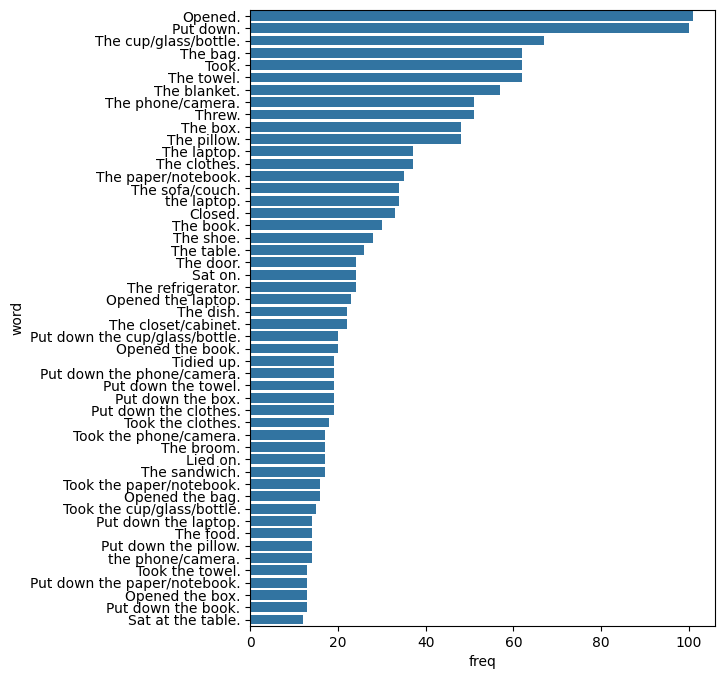

In [58]:
plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


Let's do some visualization also for the ground truth data

In [59]:
print(f"We have {gt_df['text'].nunique()} unique answers")


We have 198 unique answers


<Axes: xlabel='freq', ylabel='word'>

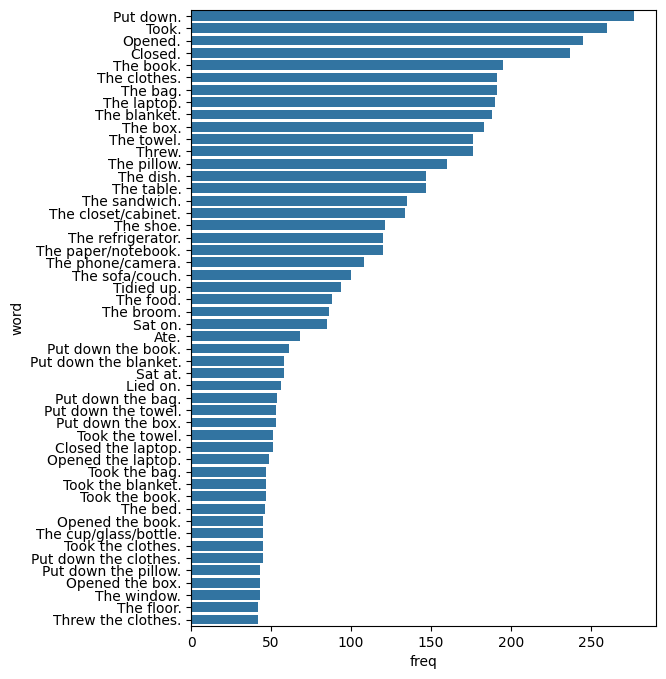

In [60]:
freq = gt_df['text'].value_counts().reset_index()
freq.columns = ['word', 'freq']

plt.figure(figsize=(6, 8))
sns.barplot(data=freq.sort_values('freq', ascending=False)[:50], x='freq', y='word')


In [61]:
# Inner join - keeps only indices present in both series

ans_df.rename(columns={'text': 'pred_text'}, inplace=True)
eval_df = gt_df.join(
    ans_df, 
    how='inner' # we account also for samples without answers
)

eval_df.shape


(2038, 5)

In [62]:
def accuracy(eval_df, on_what='text'):
    hits_text = (eval_df[f'pred_{on_what}'].str.lower() == eval_df[on_what].str.lower()).sum()
    

    return hits_text/eval_df.shape[0]


check if the equality with NA result in a false or is skipped

In [63]:
real_acc = accuracy(eval_df) * eval_df.shape[0] / gt_df.shape[0]

print(f"Real Accuracy: {real_acc:.2%}")


Real Accuracy: 13.76%


In [64]:
def print_acc(eval_df, acc_fn):
    print(f"{'Question type':<15}{'Total':^15}{'Accuracy':^10}\n")

    total = eval_df.index.str.startswith('Interaction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Interaction')])
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Sequence').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Sequence')])
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Prediction').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Prediction')])
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = eval_df.index.str.startswith('Feasibility').sum()
    acc = acc_fn(eval_df[eval_df.index.str.startswith('Feasibility')])
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")


In [65]:
print_acc(eval_df, lambda x: accuracy(x, on_what='text'))


Question type       Total      Accuracy 

Interaction          692        50.14%  
Sequence            1023        47.31%  
Prediction           175        49.71%  
Feasibility          148        39.86%  


In [66]:
# % of answers conforming to template per category

def print_ans_perc(eval_df, gt_df):
    print(f"{'Question type':<15}{'Total':^15}{'Answered':^10}\n")

    total = gt_df.index.str.startswith('Interaction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Interaction')].index))/total
    print(f"{'Interaction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Sequence').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Sequence')].index))/total
    print(f"{'Sequence':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Prediction').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Prediction')].index))/total
    print(f"{'Prediction':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.index.str.startswith('Feasibility').sum()
    acc = len(gt_df.index.intersection(eval_df[eval_df.index.str.startswith('Feasibility')].index))/total
    print(f"{'Feasibility':<15}{total:^15}{acc:^10.2%}")

    total = gt_df.shape[0]
    acc = eval_df.shape[0]/total
    print(f"{'Overall':<15}{total:^15}{acc:^10.2%}")

print_ans_perc(eval_df, gt_df)


Question type       Total      Answered 

Interaction         2398        28.86%  
Sequence            3586        28.53%  
Prediction           624        28.04%  
Feasibility          490        30.20%  
Overall             7098        28.71%  
